In [1]:
import pandas as pd
import seaborn as sns

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pydot

from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus


In [2]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('sentiment_data.csv')

# Dropped repeating values, concatinated both data frames
df2.drop(['Unnamed: 0', 'dom_color', 'AdoptionSpeed', 'has_eng_description'], axis=1, inplace=True)
df = pd.merge(df1, df2, on='PetID')

df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,doc_mag_corr,doc_score,sent_count,sen1_magnitude,sen1_score
0,2,Nibble,3,299,0,1,1,7,0,1,...,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,0.400000,0.3,6.0,0.8,0.8
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,0.350000,-0.2,2.0,0.1,0.1
2,1,Brisco,1,307,0,1,2,7,0,2,...,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,0.528571,0.2,7.0,0.9,-0.9
3,1,Miko,4,307,0,2,1,2,0,2,...,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,0.900000,0.9,1.0,0.9,0.9
4,1,Hunter,1,307,0,1,1,0,0,2,...,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,0.616667,0.6,6.0,0.7,0.7


In [3]:
df.info()
# 11 missing descriptions, the rest of the data is complete

# Checking how many pets are with unspecified maturity size
df.shape[0]-np.count_nonzero(df['MaturitySize'])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 0 to 14992
Data columns (total 29 columns):
Type              14993 non-null int64
Name              13736 non-null object
Age               14993 non-null int64
Breed1            14993 non-null int64
Breed2            14993 non-null int64
Gender            14993 non-null int64
Color1            14993 non-null int64
Color2            14993 non-null int64
Color3            14993 non-null int64
MaturitySize      14993 non-null int64
FurLength         14993 non-null int64
Vaccinated        14993 non-null int64
Dewormed          14993 non-null int64
Sterilized        14993 non-null int64
Health            14993 non-null int64
Quantity          14993 non-null int64
Fee               14993 non-null int64
State             14993 non-null int64
RescuerID         14993 non-null object
VideoAmt          14993 non-null int64
Description       14981 non-null object
PetID             14993 non-null object
PhotoAmt          14993 non-n

0

In [3]:
# Remove object data, which does not contribute to analysis
del df["Name"]
del df["RescuerID"]
del df["Description"]
del df["PetID"]

# dog's only data frame
dogs=df.loc[df['Type'] == 1]

# cat's only data frame
cats=df.loc[df['Type'] == 2]

# dog fraction. We can see dogs and cats are approximately equally distributed
dogs.shape[0]/df.shape[0]

# 71.7% of the pets are of mixed breeds
(df.shape[0]-np.count_nonzero(df['Breed2']))/df.shape[0]

# 69.1% of dogs are of mixed breeds
(dogs.shape[0]-np.count_nonzero(dogs['Breed2']))/dogs.shape[0]

# 74.8% of cats are of mixed breeds
(cats.shape[0]-np.count_nonzero(cats['Breed2']))/cats.shape[0]

# "mixed breed" (307) is most common dog's "breed"
pureDogs = dogs.loc[dogs['Breed2'] == 0]
np.bincount(pureDogs['Breed1']).argmax()

# "Domestic short hair" (266) is the most popular cat "breed" 
pureCats=cats.loc[cats['Breed2'] == 0]
np.bincount(pureCats['Breed1']).argmax()



266

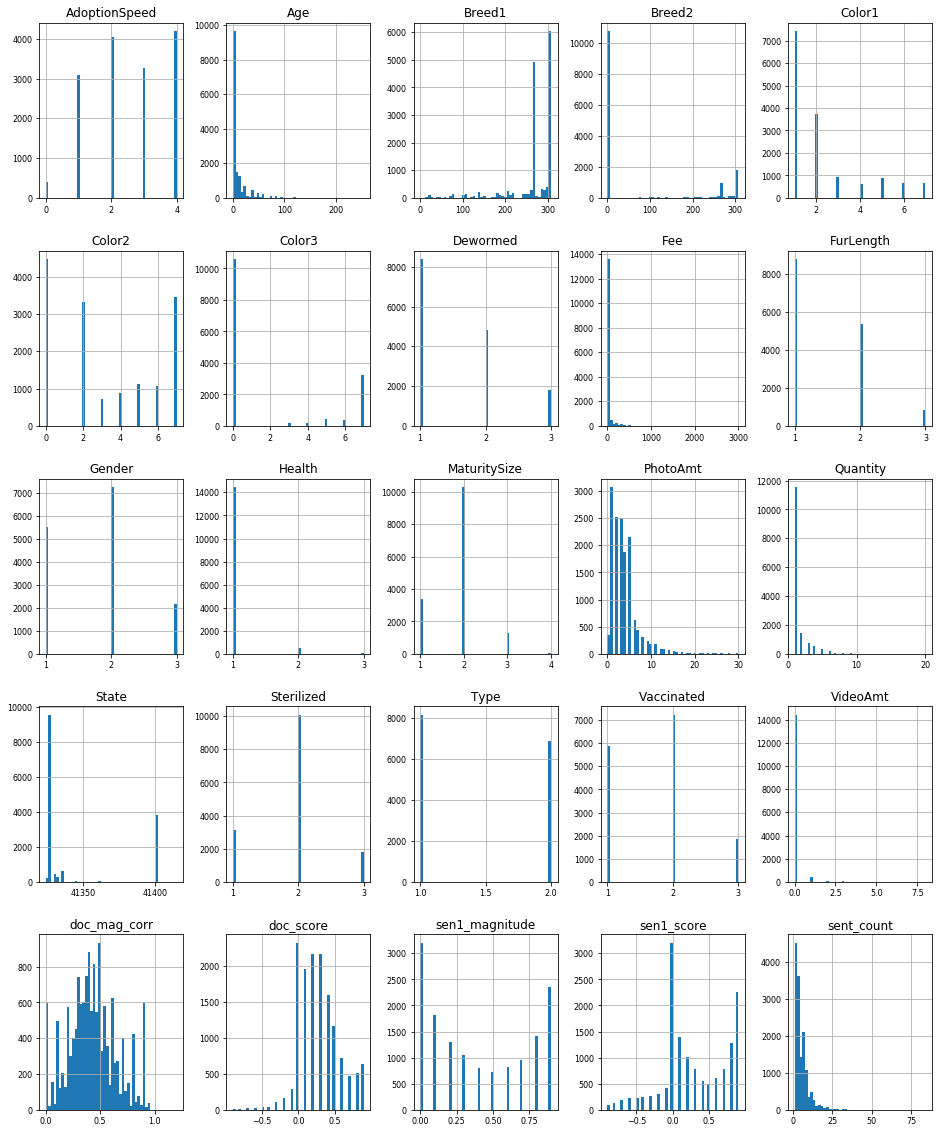

In [5]:
# Most pets moderately fast or late. Most pets are babies, short-haired, medium size. Number of photos is better 
# predictor than number of videos. Most are neither sterialized, nor vaccinated.

df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [6]:
pd.crosstab(df.AdoptionSpeed, df.MaturitySize)

MaturitySize,1,2,3,4
AdoptionSpeed,,,,
0,139,226,43,2
1,870,1909,304,7
2,884,2837,305,11
3,641,2360,248,10
4,861,2973,360,3


In [7]:
# Maturity size does not seem to affect much the adoption speed
pd.crosstab(df.MaturitySize, df.AdoptionSpeed).apply(lambda r: r/r.sum(), axis=1)

AdoptionSpeed,0,1,2,3,4
MaturitySize,,,,,
1,0.040943,0.256259,0.260383,0.188807,0.253608
2,0.021931,0.185250,0.275303,0.229015,0.288501
3,0.034127,0.241270,0.242063,0.196825,0.285714
4,0.060606,0.212121,0.333333,0.303030,0.090909


In [8]:
pd.crosstab(cats.MaturitySize, cats.AdoptionSpeed).apply(lambda r: r/r.sum(), axis=1)

AdoptionSpeed,0,1,2,3,4
MaturitySize,,,,,
1,0.040976,0.270258,0.264273,0.182320,0.242173
2,0.030397,0.222834,0.283629,0.196027,0.267113
3,0.044000,0.272000,0.226000,0.182000,0.276000
4,0.181818,0.090909,0.090909,0.363636,0.272727


In [9]:
pd.crosstab(dogs.MaturitySize, dogs.AdoptionSpeed).apply(lambda r: r/r.sum(), axis=1)

AdoptionSpeed,0,1,2,3,4
MaturitySize,,,,,
1,0.040883,0.231398,0.253475,0.200327,0.273917
2,0.016158,0.159621,0.269626,0.251510,0.303085
3,0.027632,0.221053,0.252632,0.206579,0.292105
4,0.000000,0.272727,0.454545,0.272727,0.000000


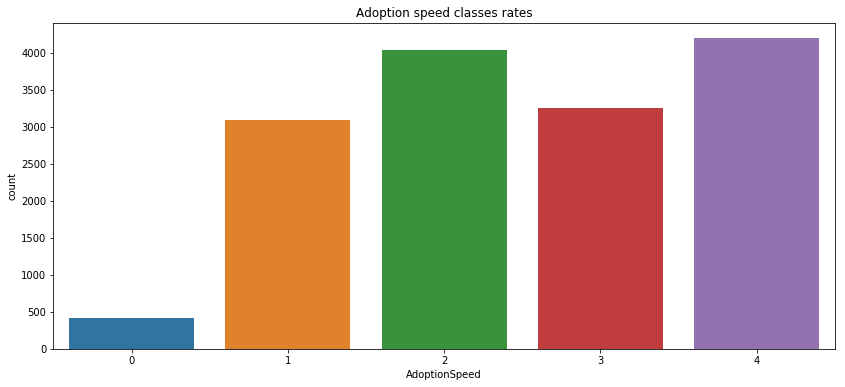

In [10]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=df);
plt.title('Adoption speed classes rates');
ax=g.axes

In [4]:
df = df.dropna()
adoptionSpeed=df['AdoptionSpeed']
del df["AdoptionSpeed"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14442 entries, 0 to 14992
Data columns (total 24 columns):
Type              14442 non-null int64
Age               14442 non-null int64
Breed1            14442 non-null int64
Breed2            14442 non-null int64
Gender            14442 non-null int64
Color1            14442 non-null int64
Color2            14442 non-null int64
Color3            14442 non-null int64
MaturitySize      14442 non-null int64
FurLength         14442 non-null int64
Vaccinated        14442 non-null int64
Dewormed          14442 non-null int64
Sterilized        14442 non-null int64
Health            14442 non-null int64
Quantity          14442 non-null int64
Fee               14442 non-null int64
State             14442 non-null int64
VideoAmt          14442 non-null int64
PhotoAmt          14442 non-null float64
doc_mag_corr      14442 non-null float64
doc_score         14442 non-null float64
sent_count        14442 non-null float64
sen1_magnitude    14442 n

Feature ranking:
1. feature 19 (0.096227)
2. feature 1 (0.084644)
3. feature 18 (0.080239)
4. feature 21 (0.074707)
5. feature 20 (0.065025)
6. feature 23 (0.060956)
7. feature 22 (0.054913)
8. feature 2 (0.054862)
9. feature 6 (0.051940)
10. feature 5 (0.049449)
11. feature 16 (0.038013)
12. feature 3 (0.034134)
13. feature 9 (0.028824)
14. feature 4 (0.028506)
15. feature 8 (0.027464)
16. feature 14 (0.027364)
17. feature 7 (0.025733)
18. feature 15 (0.025002)
19. feature 11 (0.023601)
20. feature 12 (0.023549)
21. feature 10 (0.022496)
22. feature 0 (0.009210)
23. feature 17 (0.007066)
24. feature 13 (0.006073)


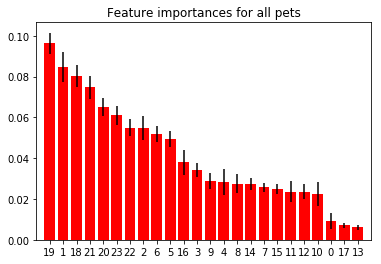

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Separate the data into train and test randomly
df_train, df_test, adoptionSpeed_train, adoptionSpeed_test = train_test_split(df, adoptionSpeed, test_size=0.2)
model = RandomForestClassifier(n_estimators=500) # n_estimators number of decision trees

# Train a random forest classifier for feature importance for all pets
model.fit(df_train, adoptionSpeed_train)

importances = model.feature_importances_
std = np.std([t.feature_importances_ for t in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
labels = list(df_train.columns.values)
ordered_labels = [labels[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for all pets")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), indices)
plt.xlim([-1, df_train.shape[1]])
plt.show()

# Number of photoes and age are most important features predicting adoption speed

In [6]:
# Predictors ordered according to importance
print(ordered_labels)

# Assessing the performance of the random forest
prediction = model.predict(df_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluating the accuracy of the algorithm (these steps are the same for any classification algorithm)
# Accuracy around 40%
print(confusion_matrix(adoptionSpeed_test,prediction))  
print(classification_report(adoptionSpeed_test,prediction))  
print(accuracy_score(adoptionSpeed_test, prediction))  

['doc_mag_corr', 'Age', 'PhotoAmt', 'sent_count', 'doc_score', 'sen1_score', 'sen1_magnitude', 'Breed1', 'Color2', 'Color1', 'State', 'Breed2', 'FurLength', 'Gender', 'MaturitySize', 'Quantity', 'Color3', 'Fee', 'Dewormed', 'Sterilized', 'Vaccinated', 'Type', 'VideoAmt', 'Health']
[[  4  25  25   7  20]
 [  2 183 191  56 117]
 [  0 160 317 110 200]
 [  0 104 195 159 172]
 [  0  67 141  68 566]]
             precision    recall  f1-score   support

          0       0.67      0.05      0.09        81
          1       0.34      0.33      0.34       549
          2       0.36      0.40      0.38       787
          3       0.40      0.25      0.31       630
          4       0.53      0.67      0.59       842

avg / total       0.42      0.43      0.41      2889

0.4254067151263413


In [7]:
# Creating a new data frame with only the 10 most important features for the train and test
feature_train=df_train.iloc[:, indices[0]]
feature_test=df_test.iloc[:, indices[0]]

for i in range(1, 10):
    subset1 = df_train.iloc[ : ,indices[i]]
    subset2 = df_test.iloc[ : ,indices[i]]
    feature_train = pd.concat([feature_train, subset1], axis=1)
    feature_test = pd.concat([feature_test, subset2], axis=1)

feature_test.info()
feature_train.info()

# Random forest on 10 most important features, accuracy 38% (random forest with all variables performs better)
model.fit(feature_train, adoptionSpeed_train)
tree_prediction = model.predict(feature_test)
print(classification_report(adoptionSpeed_test,tree_prediction))  
print(accuracy_score(adoptionSpeed_test, tree_prediction))  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2889 entries, 7140 to 3080
Data columns (total 10 columns):
doc_mag_corr      2889 non-null float64
Age               2889 non-null int64
PhotoAmt          2889 non-null float64
sent_count        2889 non-null float64
doc_score         2889 non-null float64
sen1_score        2889 non-null float64
sen1_magnitude    2889 non-null float64
Breed1            2889 non-null int64
Color2            2889 non-null int64
Color1            2889 non-null int64
dtypes: float64(6), int64(4)
memory usage: 248.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11553 entries, 2464 to 8055
Data columns (total 10 columns):
doc_mag_corr      11553 non-null float64
Age               11553 non-null int64
PhotoAmt          11553 non-null float64
sent_count        11553 non-null float64
doc_score         11553 non-null float64
sen1_score        11553 non-null float64
sen1_magnitude    11553 non-null float64
Breed1            11553 non-null int64
Color2     

In [9]:
# Support vector machine: tried all parameter settings, best accuracy 36%
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(feature_train, adoptionSpeed_train) 

clf_prediction=clf.predict(feature_test)
print(confusion_matrix(adoptionSpeed_test,clf_prediction))  
print(classification_report(adoptionSpeed_test,clf_prediction))  
print(accuracy_score(adoptionSpeed_test, clf_prediction))  

clf_full = svm.SVC(decision_function_shape='ovr').fit(df_train, adoptionSpeed_train)
full_prediction = clf_full.predict(df_test)
print(accuracy_score(adoptionSpeed_test, full_prediction))

[[  0  17  26  13  25]
 [  0 117 242  50 140]
 [  0 116 376  79 216]
 [  0  77 243  95 215]
 [  0  58 219  77 488]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        81
          1       0.30      0.21      0.25       549
          2       0.34      0.48      0.40       787
          3       0.30      0.15      0.20       630
          4       0.45      0.58      0.51       842

avg / total       0.35      0.37      0.35      2889

0.3724472135687089


/home/mihaela/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3824852890273451


In [10]:
# Ordinal regression all-threshold variant, accuracy 23% regardless whether all data or selected features are
# used in the training. Documentation: https://pythonhosted.org/mord/reference.html#mord.MulticlassLogistic

# Ordinal regression immediate-threshold variant (implemented in this code currently), accuracy 30%


import mord as md
ordinal_model = md.LogisticIT(alpha=1, verbose=0)
ordinal_model.fit(feature_train, adoptionSpeed_train)

ordinal_prediction = ordinal_model.predict(feature_test)
print(classification_report(adoptionSpeed_test,ordinal_prediction))  
print(accuracy_score(adoptionSpeed_test, ordinal_prediction))  

ordinal_full = md.LogisticIT(alpha=1, verbose=0)
ordinal_full.fit(df_train, adoptionSpeed_train)
ordinalFull_prediction = ordinal_full.predict(df_test)
print(classification_report(adoptionSpeed_test,ordinalFull_prediction))  
print(accuracy_score(adoptionSpeed_test, ordinalFull_prediction))  


/home/mihaela/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        81
          1       0.26      0.08      0.12       549
          2       0.30      0.45      0.36       787
          3       0.00      0.00      0.00       630
          4       0.38      0.69      0.49       842

avg / total       0.24      0.34      0.26      2889

0.33852544132917967
             precision    recall  f1-score   support

          0       0.33      0.01      0.02        81
          1       0.26      0.14      0.18       549
          2       0.28      0.35      0.31       787
          3       0.23      0.27      0.25       630
          4       0.40      0.42      0.41       842

avg / total       0.30      0.30      0.29      2889

0.30183454482519906


In [12]:
# Slightly worse than a random forest, accuracy 39%
# Runs for 20 min
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

# Looks through all these parameter settings to find the best ones, takes a while to run (15min)
# Grid search can be applied to any model, not only to the gradient boosting classifier.
parameters = {'learning_rate':[0.01, 0.07, 0.1], 'max_leaf_nodes':[5, 7, 9]}
gbc_model = GradientBoostingClassifier(n_estimators=500, random_state=0)
clf = GridSearchCV(gbc_model, parameters, cv=5)
clf.fit(df_train, adoptionSpeed_train)
clf_prediction = clf.predict(df_test)
print(accuracy_score(adoptionSpeed_test, clf_prediction))

0.42021460713049497


In [13]:
from sklearn.ensemble import AdaBoostClassifier
adaBoost_model = AdaBoostClassifier(base_estimator=None, n_estimators=500, 
                   learning_rate=0.5, algorithm='SAMME.R', random_state=None).fit(feature_train, adoptionSpeed_train)
adaBoost_model.score(feature_test, adoptionSpeed_test)


0.3817930079612323

In [14]:
# Random Forest + grid search cv + adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

# Parameter settings to explore
parameters = {'max_depth':[2, 3, 4], 'min_samples_split':[2, 10, 50]}
random_forest = RandomForestClassifier(n_estimators=500)
gridsearch_forest = GridSearchCV(random_forest, parameters, cv=5)
gridsearch_forest.fit(df_train, adoptionSpeed_train)

# Gives the most optimal settings from the parameters space
best_parameters = gridsearch_forest.best_params_

# Retrain the model on best settings
best_forest = RandomForestClassifier(n_estimators=100, **best_parameters)

# Boost the model with base random forest
ada_boost = AdaBoostClassifier(base_estimator=best_forest)
ada_boost.fit(df_train, adoptionSpeed_train)
ada_predicted = ada_boost.predict(df_test)
print(accuracy_score(adoptionSpeed_test, ada_predicted))


0.41675320179993075
